In [1]:
import numpy as np
import pandas as pd
from src.models import get_belief_model
from scipy.special import expit
import pymc as pm
import arviz as az
import json
import os
import seaborn as sns

use_cpu = True


def make_dir(newpath):
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
try: 
    import pymc.sampling.jax as pmjaxz
    from jax.lib import xla_bridge
    import matplotlib.pyplot as plt
    print(xla_bridge.get_backend().platform)
    if xla_bridge.get_backend().platform == 'gpu':
        use_cpu = False
    import pymc.sampling.jax as pmjax
except:
    print("No JAX backend")
    use_cpu = True

params = json.load(open('params.json'))
np.random.seed(params['seed'])

%load_ext autoreload
%autoreload 2
%autosave 30

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


gpu


Autosaving every 30 seconds


# Step One: Conceptual Analysis
Participants, from various countries, have been asked to share climate change information on social media. We are interested in whether treatments, countries, or their estimated pre-treatment belief impact sharing rates. 


# Step Two: Define Conceptual Space
Outcomes are binary with a single outcome for each participant.

# Step Three: Construct summary statistics 
We will not create any specific summary statsitics. 

# Step Four: Model Development

Our outcome variable (Social Media Sharing), examines whether participants are willing to share climate change information online. It is a binary variable, making a Bernoulli likelihood a reasonable choice. Unlike other outcomes, we don't have to worry about inflation, mixture models, or any of that complexity. Instead, we'll just adopt the model we used for WEPT (see model_fitting_wept.ipynb). 


\begin{align}
y &\sim \text{Bernoulli}(\theta_i)\\
\theta_i &= \text{InverseLogit}(\mu_i)\\
\alpha&\sim\text{Normal}(0,1)\\
\beta&\sim\text{Normal}(0,1)\\
\mu_i &= \alpha + \beta X + \text{C}_{0, c[i]} +  \text{C}_{1,c[i]}X +  \text{T}_{0, t[i]} + \text{T}_{0, t[i]} X \\
C, T&\sim \text{MVNormal} \big(\begin{bmatrix}0\\0\end{bmatrix},S\big)\\
S&=\big(\begin{matrix}\sigma_a & 0 \\ 0 & \sigma_b \end{matrix}\big) R \big(\begin{matrix}\sigma_a & 0 \\ 0 & \sigma_b \end{matrix}\big)\\
\sigma_{\alpha}, \sigma_{\beta} &\sim \text{Exponential}(4) \\
R &\sim{LKJCorr(2)}\\
\end{align}




Here $\alpha$ and $\beta$ are shared intercepts and effects of belief, where $C$ and $T$ are matrices that describe intercepts and impacts of belief for each country and treatment respectively. These effects are pooled using a multivariate normal distribution and an LKJCholesky prior. For computational considerations, we implement this model using a non-centered parameterization. 

# Step Five: Construct Summary Statistics
We will qualitatively assess the probability of sharing, across prior simulations

In [2]:
import pandas as pd
df = pd.read_excel(params['data']['adj_location'])
df.head()

,Unnamed: 0,ResponseId,Country,cond,condName,Intervention_order,Intro_Timer,Intervention_Timer,BELIEFcc,POLICYcc,...,Gender,Age,Edu,Politics2_1,Politics2_9,Income,MacArthur_SES,PerceivedSciConsensu_1,UniqueID,BeliefADJ
0,0,R_3KOO2oUWQNtKzrD,Algeria,8,PluralIgnorance,PolicySupport|SocialmediasharingPipedText|Beli...,7.074,28.758,100.00,64.666667,...,1.0,25.0,3.0,53.0,53.0,4.0,4.0,86.0,0,3.642990
1,1,R_3OdqhjO2quQKaIx,Algeria,12,BindingMoral,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,32.089,27.999,73.25,58.111111,...,1.0,35.0,4.0,92.0,36.0,6.0,10.0,31.0,1,1.334043
2,2,R_2QuK4DRmnWL9FXS,Algeria,10,DynamicNorm,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,17.598,54.658,3.00,56.555556,...,3.0,18.0,2.0,100.0,88.0,9.0,4.0,50.0,2,-1.626310
3,3,R_1DYkviJgtp5u6JV,Algeria,7,PsychDistance,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,10.951,299.309,90.75,95.555556,...,1.0,32.0,3.0,93.0,82.0,2.0,3.0,4.0,3,2.011489
4,4,R_1rqWNg0k27FgrE4,Algeria,12,BindingMoral,PolicySupport|BeliefinAnthrCC|Socialmediashari...,5.465,7.302,76.50,67.250000,...,2.0,29.0,4.0,NaN,NaN,3.0,7.0,100.0,4,2.066036


In [3]:
params = json.load(open('params.json'))
params['share']['priors']

{'lambda_val': 4, 'alpha_sigma': 1, 'beta_sigma': 1}

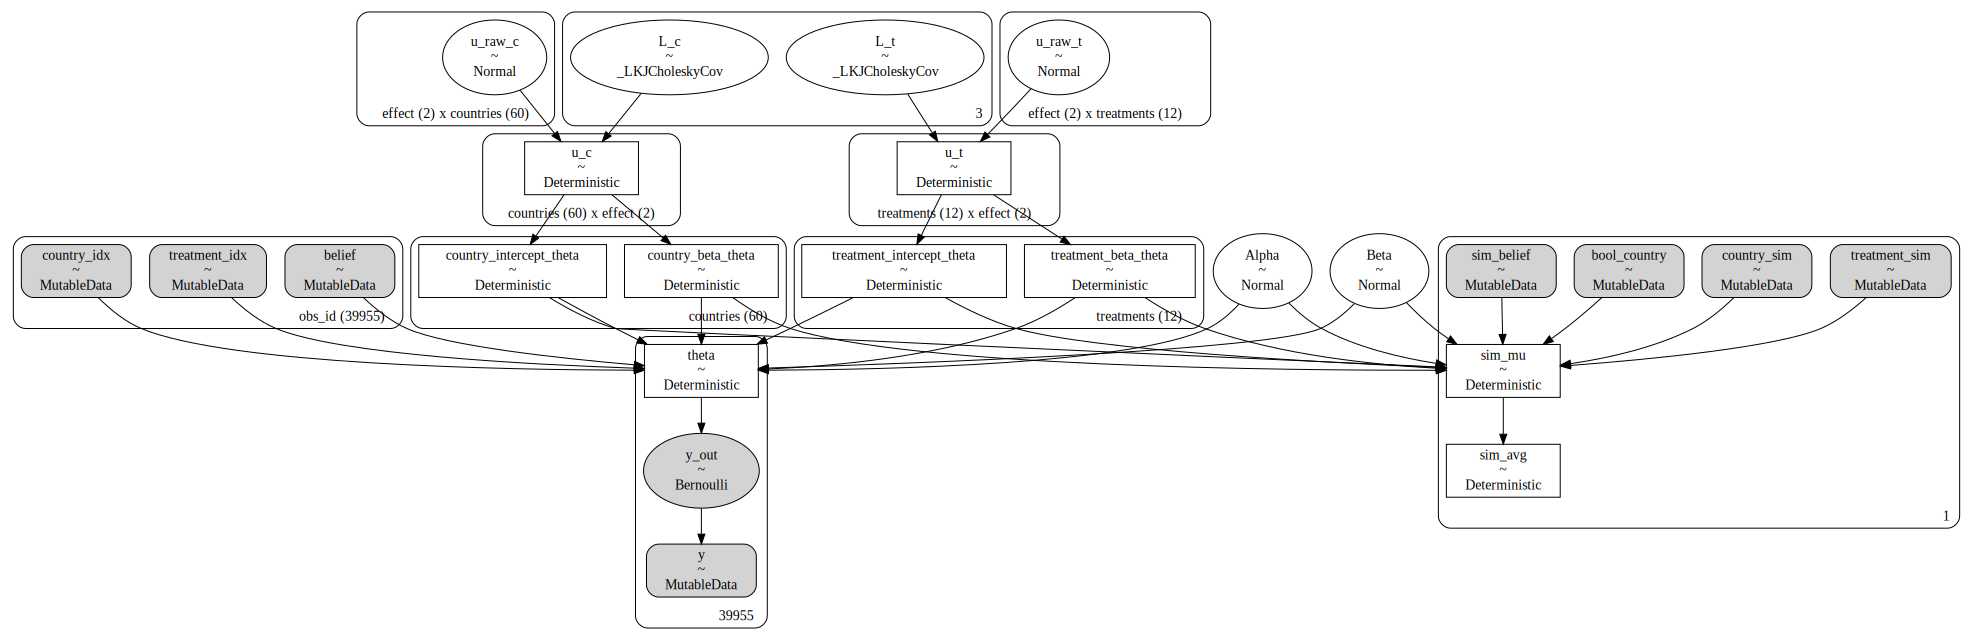

In [4]:
from src.models import get_share_model


model, _, temp = get_share_model(df, priors = params['share']['priors'])

pm.model_to_graphviz(model)

# Step Six: Simulate Bayesian Ensemble

With our priors and model loaded, we can simulate the implications of our structure and prior choice to determine whether we have chosen appropriate priors. Should they appear off, they can be adjusted in `params.json` and reloaded. 


In [5]:
with model: 
    prior_predictive = pm.sample_prior_predictive(samples = params['share']['prior_predictive_samples'],
                                                  random_seed=params['seed'])

az.to_netcdf(prior_predictive, './out/posteriors/prior_predictive_share.nc')

/home/ubuntu/.local/lib/python3.8/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Sampling: [Alpha, Beta, L_c, L_t, u_raw_c, u_raw_t, y_out]


'./out/posteriors/prior_predictive_share.nc'

# Step seven: Prior Predictive Checks
Here, we verify that our prior choices produce distributions of sharing consistent with our domain knowledge. For a logistic regression, there is not a lot to this step

<ipython-input-6-d8e3991b97c9>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


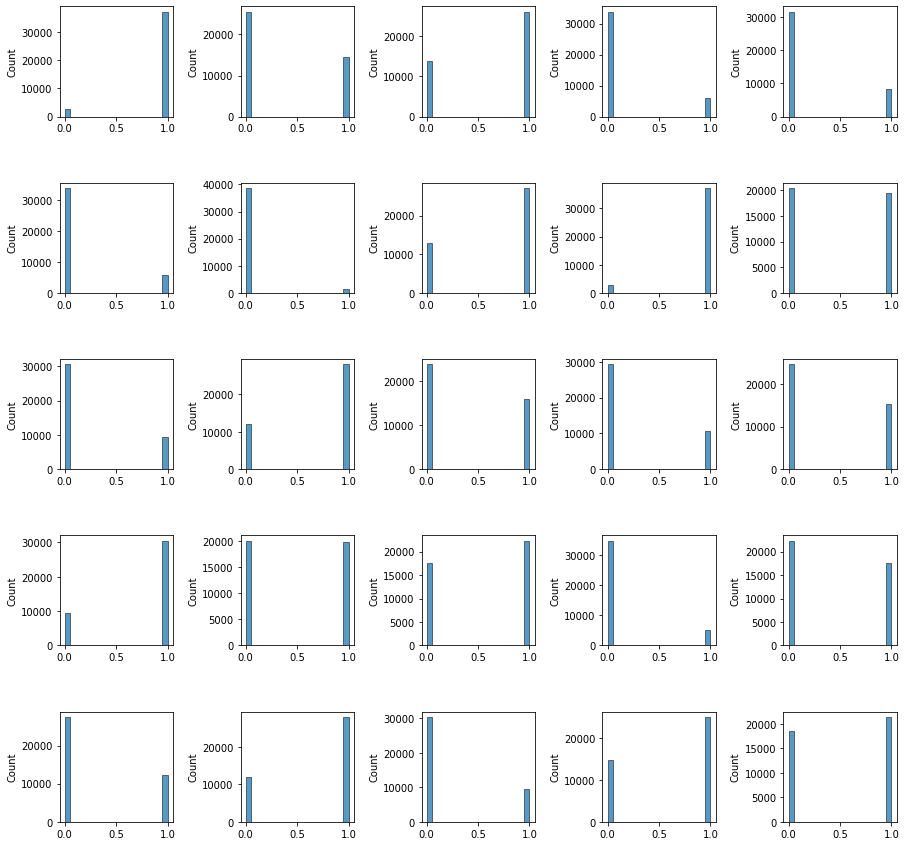

In [6]:
prior_pd = prior_predictive.prior_predictive['y_out']

plt.figure(figsize=(15, 15))
g = plt.GridSpec(5, 5, hspace=0.6, wspace=0.6)

for i in range(5):
    for j in range(5):
        ax = plt.subplot(g[i, j])
        sns.histplot(prior_pd[0, np.random.choice(np.arange(prior_pd.shape[1])), :], bins=np.linspace(-.0, 1.0, 21))
plt.tight_layout()



# Step Eight: Configure Algorithm
We will use default parameters to sample on the GPU. Tune and Draw can be adjusted in params.json

# Step Nine: Fit Simulated Ensemble
As this is computationally challenging, we face some trade-offs between running the model at the full data volume and running the model on sufficient numbers of prior samples to draw conclusions about the inferential adequacy. We will run only 6 fits from the prior distribution. 


In [7]:
#Add zero constrain on control treatment effects. 
from pymc.sampling import jax as pmjax
prior_num = 0

for prior_num in np.random.choice(np.arange(params['share']['prior_predictive_samples']), size=6):
    print('Running inference on prior sample: ', prior_num)
    ranked_data = []
    with model:
        model.set_data('y', prior_predictive.prior_predictive['y_out'].data[0][prior_num])
        if use_cpu:
            idata = pm.sample(tune = params['belief']['tune'], draws = params['belief']['draws'], random_seed=params['seed'])
        else: 
            idata = pmjax.sample_numpyro_nuts(chain_method=params['sampling']['chain_method'],
                                        postprocessing_backend=params['sampling']['postprocessing_backend'], 
                                        tune =500, 
                                        draws = 500, random_seed=params['seed'])
        
        out = []
        var_names = ['u_t', 'u_c', 'Alpha', 'Beta','theta']
        for name in var_names:
            ranks = (prior_predictive.prior[name].data[0, prior_num] < idata.posterior[name]).sum(dim='chain').sum(dim='draw')
            means =idata.posterior[name].mean(dim=['chain', 'draw'])
            sd = idata.posterior[name].std(dim=['chain', 'draw'])
            prior_var = prior_predictive.prior[name].var(dim=['chain', 'draw'])
            prior_sd = prior_predictive.prior[name].std(dim=['chain', 'draw'])
            prior_mu= prior_predictive.prior[name].mean(dim=['chain', 'draw'])
            prior = prior_predictive.prior[name].data[0, prior_num] 
            var = idata.posterior[name].var(dim=['chain', 'draw'])
            out.append({'name':np.repeat(name, ranks.size),
                        'prior_num':np.repeat(prior_num, ranks.size),
                        'rank':ranks.values.ravel(),
                        'means':means.values.ravel(), 
                        'sd':sd.values.ravel(),
                        'var':var.values.ravel(),
                        'prior_var':prior_var.values.ravel(),
                        'prior_sd':prior_sd.values.ravel(),
                        'prior':prior.ravel(),
                        'prior_mu':prior_mu.values.ravel()})
        ranked_data.append(pd.concat(pd.DataFrame(x) for x in out))

        print('BFMI:')
        print(az.bfmi(idata))
        print('Rhat:')
        print(np.sum(az.summary(idata, var_names=var_names)['r_hat'] > 1.05))
        print('ess_bulk: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_bulk'].min()))
        print('ess_tail: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_tail'].min()))
        print('Divergeneces:')
        print(idata.sample_stats['diverging'].sum())
        #idata = pm.sample(tune = params['belief']['tune'], draws = params['belief']['draws'], random_seed=params['seed']) \

    
        pd.concat(ranked_data).to_csv('./out/share_prior_ranks2.csv')
    print('-------------------------------------')

Running inference on prior sample:  413
Compiling...
Compilation time =  0:00:05.321583
Sampling...


sample: 100%|██████████| 1000/1000 [02:32<00:00,  6.58it/s]


Sampling time =  0:02:48.202446
Transforming variables...
Transformation time =  0:00:02.293787
BFMI:
[0.53003723 0.84187573 0.74484888 0.7067968 ]
Rhat:
0
ess_bulk: min
419.0
ess_tail: min
676.0
Divergeneces:
<xarray.DataArray 'diverging' ()>
array(0)
-------------------------------------
Running inference on prior sample:  293
Compiling...
Compilation time =  0:00:04.813053
Sampling...


sample: 100%|██████████| 1000/1000 [12:22<00:00,  1.35it/s]


Sampling time =  0:12:23.485983
Transforming variables...
Transformation time =  0:00:01.713509
BFMI:
[0.66843923 1.06635185 0.75104994 0.70011463]
Rhat:
33734
ess_bulk: min
7.0
ess_tail: min


KeyboardInterrupt: 

Examining the posterior predictive contraction vs. z-scores of known parameters is strongly clustered on the right of the graph near zero, with few extreme observations. This suggests adequate model fit, balancing overfit and underfit, and priors that are not causing the model to behave poorly. We will continue fitting the model. 

# Step Ten: Algorithmic Calibration
We're going to increase samples to allow for better convergence. We did not observe divergent transitions or issues with eBFMI.

# Step Eleven: Inferential Calibration
This leaves us to check the ensemble behavior of our recovered posterior distributions which looks reasonable for both parameters.

In [2]:
df_temp = pd.read_csv('./out/share_prior_ranks2.csv')

In [3]:
df_temp['z_score'] = (df_temp['means']-df_temp['prior'])/df_temp['prior_sd']
df_temp['contraction'] = 1-df_temp['var']/df_temp['prior_var']

Text(0, 0.5, 'Posterior Z-Score')

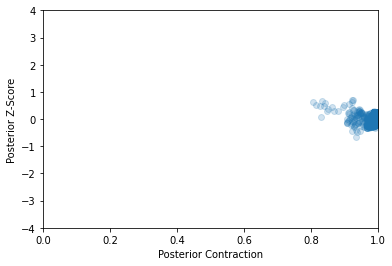

In [4]:

df_temp=df_temp[df_temp['means']!=0]
plt.scatter(df_temp['contraction'], df_temp['z_score'], alpha=.2)
plt.xlim(0,1)
plt.ylim(-4, 4)
plt.xlabel('Posterior Contraction')
plt.ylabel('Posterior Z-Score')

# Step Twelve: Fit the Observation

Confident in the performance of our model within the scope of its own assumptions we go back to fit the observed data. 

In [5]:
#reload data, parameters

params = json.load(open('params.json'))
df = pd.read_excel(params['data']['adj_location'])

df.head()


,Unnamed: 0,ResponseId,Country,cond,condName,Intervention_order,Intro_Timer,Intervention_Timer,BELIEFcc,POLICYcc,...,Gender,Age,Edu,Politics2_1,Politics2_9,Income,MacArthur_SES,PerceivedSciConsensu_1,UniqueID,BeliefADJ
0,0,R_3KOO2oUWQNtKzrD,Algeria,8,PluralIgnorance,PolicySupport|SocialmediasharingPipedText|Beli...,7.074,28.758,100.00,64.666667,...,1.0,25.0,3.0,53.0,53.0,4.0,4.0,86.0,0,3.642990
1,1,R_3OdqhjO2quQKaIx,Algeria,12,BindingMoral,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,32.089,27.999,73.25,58.111111,...,1.0,35.0,4.0,92.0,36.0,6.0,10.0,31.0,1,1.334043
2,2,R_2QuK4DRmnWL9FXS,Algeria,10,DynamicNorm,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,17.598,54.658,3.00,56.555556,...,3.0,18.0,2.0,100.0,88.0,9.0,4.0,50.0,2,-1.626310
3,3,R_1DYkviJgtp5u6JV,Algeria,7,PsychDistance,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,10.951,299.309,90.75,95.555556,...,1.0,32.0,3.0,93.0,82.0,2.0,3.0,4.0,3,2.011489
4,4,R_1rqWNg0k27FgrE4,Algeria,12,BindingMoral,PolicySupport|BeliefinAnthrCC|Socialmediashari...,5.465,7.302,76.50,67.250000,...,2.0,29.0,4.0,NaN,NaN,3.0,7.0,100.0,4,2.066036


In [6]:
from src.models import get_share_model
model, df, temp = get_share_model(df, params['share']['priors'])

In [7]:
with model:
    if use_cpu: 
        idata = pm.sample(cores = params['sampling']['cores'], 
                        tune = params['share']['tune'],
                        draws = params['share']['draws'], 
                        random_seed=params['seed'], 
                        target_accept=params['belief']['target_accept'])
    else:
        idata = pmjax.sample_numpyro_nuts(chain_method=params['sampling']['chain_method'],
                                        postprocessing_backend=params['sampling']['postprocessing_backend'], 
                                        tune = params['share']['tune'],
                                        draws = params['share']['draws'], random_seed=params['seed'])
az.to_netcdf(idata, params['share']['idata_location'])

Compiling...


/home/ubuntu/.local/lib/python3.8/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


Compilation time =  0:00:05.628521
Sampling...


sample: 100%|██████████| 3000/3000 [05:04<00:00,  9.84it/s]


Sampling time =  0:05:20.916172
Transforming variables...
Transformation time =  0:00:06.504883


'./out/posteriors/share.nc'

#  Step Thirteen: Diagnose posterior fit

In [8]:
idata.sample_stats['diverging'].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [9]:
az.summary(idata, var_names=['u_t', 'u_c', 'Alpha', 'Beta']).sort_values('r_hat', ascending=False)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"u_c[Greece, intercept]",0.502,0.190,0.137,0.850,0.006,0.004,1002.0,2347.0,1.01
"u_c[Italy, intercept]",0.190,0.194,-0.176,0.537,0.006,0.004,1036.0,2389.0,1.01
"u_c[Austria, intercept]",-0.952,0.230,-1.378,-0.522,0.006,0.004,1404.0,3207.0,1.01
"u_c[Germany, intercept]",-0.938,0.180,-1.270,-0.590,0.006,0.004,903.0,1809.0,1.01
"u_c[Russian Federation, intercept]",-1.252,0.181,-1.596,-0.913,0.006,0.004,897.0,1899.0,1.01
...,...,...,...,...,...,...,...,...,...
"u_c[China, slope]",0.331,0.124,0.111,0.574,0.001,0.001,7754.0,6141.0,1.00
"u_c[China, intercept]",0.464,0.255,-0.038,0.917,0.006,0.005,1606.0,3536.0,1.00
"u_c[Chile, slope]",0.125,0.079,-0.028,0.268,0.001,0.001,9039.0,6241.0,1.00
"u_c[Chile, intercept]",0.363,0.246,-0.084,0.839,0.006,0.004,1625.0,3643.0,1.00


In [10]:
az.bfmi(idata)

array([0.69336024, 0.7284981 , 0.65594118, 0.71274932])

#  Step Fourteen: Posterior Retrodictive Fit

In [11]:
with model:
   ppc = pm.sample_posterior_predictive(idata, var_names=["y_out"])


Sampling: [y_out]


In [12]:
df['y_hat'] = ppc.posterior_predictive['y_out'].mean(dim=['chain', 'draw'])
df['count'] = np.ones(df.shape[0])

grouped = df.groupby(['condName', 'Country']).mean(numeric_only=True).reset_index()
group_count = df.groupby(['condName', 'Country']).count().reset_index()

Text(0, 0.5, 'Observed Sharing')

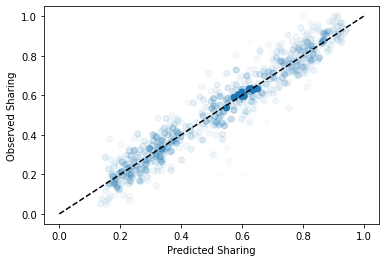

In [13]:
plt.scatter( grouped['y_hat'], grouped['SHARE'],
            alpha=group_count['count']/np.max(group_count['count']))

plt.plot([0, 1], [0, 1], ls='--',color='k')
plt.xlabel('Predicted Sharing')
plt.ylabel('Observed Sharing')